# Определение перспективного тарифа для телеком-компании

Предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание данных**

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from scipy import stats as st

### Изучим данные таблицы calls (информация о звонках):

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [3]:
df_calls.info() # получаем общие сведения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
df_calls['call_date'].head()

0   2018-07-25
1   2018-08-17
2   2018-06-11
3   2018-09-21
4   2018-12-15
Name: call_date, dtype: datetime64[ns]

In [5]:
df_calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
26.94        1
32.19        1
26.32        1
27.41        1
26.90        1
Name: duration, Length: 2871, dtype: int64

In [6]:
df_calls.duplicated().sum() # проверяем наличие дубликатов

0

В таблице calls нет дубликатов и пропусков, но есть звонки длительность 0 минут и их доля мала(окло 3%), что нормально. Это объясняется наличем пропущенных звонков.

### Изучим таблицу internet (информация об интернет-сессиях):

In [7]:
df_internet = pd.read_csv('C://Users//valer//Портфолио//internet.csv')
df_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


In [9]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
df_internet['session_date'].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

In [10]:
df_internet.duplicated().sum() # проверяем наличие дубликатов

0

In [11]:
df_internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64

В таблице interne нет дубликатов и пропусков, но есть  объём потраченного за сессию интернет-трафика  0 мгб и их доля незначительна(окло 28%), что нормально. Это объясняется тем, что пользователь не пользовался услугой.

### Изучим таблицу messages (информация о сообщениях):

In [12]:
df_messages = pd.read_csv('C://Users//valer//Портфолио//messages.csv')
df_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [13]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [14]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
df_messages['message_date'].head()

0   2018-06-27
1   2018-10-08
2   2018-08-04
3   2018-06-16
4   2018-12-05
Name: message_date, dtype: datetime64[ns]

In [15]:
df_messages.duplicated().sum() # проверяем наличие дубликатов

0

В таблице messages нет дубликатов и пропусков. 

### Изучим таблицу tariffs (информация о тарифах):

In [16]:
df_tariffs = pd.read_csv('C://Users//valer//Портфолио//tariffs.csv')
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 184.0+ bytes


### Изучим таблицу users (информация о пользователях):

In [18]:
df_users = pd.read_csv('C://Users//valer//Портфолио//users.csv')
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [19]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 19.6+ KB


In [20]:
df_users.duplicated().sum() # проверяем наличие дубликатов

0

In [21]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%dT%H:%M:%S')
df_users['reg_date'].head()

0   2018-05-25
1   2018-11-01
2   2018-06-17
3   2018-08-17
4   2018-05-14
Name: reg_date, dtype: datetime64[ns]

В таблице users нет дубликатов. В столбце churn_date  есть пропуски, но они означают, что тариф ещё действовал на момент выгрузки данных

**Bывод**

Мы прверили детасеты на наличие попусков и дубликатов, выяснили причину пропусков и пришли к решению не удалять их. Также изменили тип данных связанных с датой.

**Посчитаем для каждого пользователя:**

### Количество сделанных звонков и израсходованных минут разговора по месяцам:

In [22]:
df_calls['month'] = df_calls['call_date'].dt.month

In [23]:
df_calls['duration'] = np.ceil(df_calls['duration']) # округлим в большую сторону, согласно условию

### Количество отправленных сообщений по месяцам:

In [24]:
df_messages['month'] = df_messages['message_date'].dt.month

### Oбъем израсходованного интернет-трафика по месяцам

In [25]:
df_internet['month'] = df_internet['session_date'].dt.month

### Помесячную выручку с каждого пользователя 

Для удобства соединим все таблицы в одну

In [26]:

c = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
m = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
i = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
i['gb_used'] = np.ceil(i['mb_used']/1024)
df_users['month'] = df_users['reg_date'].dt.month
us = df_users[['user_id','tariff', 'city', 'month']]
total_inf = c.merge(m, on=['user_id', 'month'], how='outer').merge(i, on=['user_id', 'month'], how='outer').merge(us, on=['user_id', 'month'],how='left').fillna(0)
total_inf

,user_id,month,duration,id,mb_used,gb_used,tariff,city
0,1000,5,159.0,22.0,2253.49,3.0,ultra,Краснодар
1,1000,6,172.0,60.0,23233.77,23.0,0,0
2,1000,7,340.0,75.0,14003.64,14.0,0,0
3,1000,8,408.0,81.0,14055.93,14.0,0,0
4,1000,9,466.0,57.0,14568.91,15.0,0,0
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,32.0,17206.30,17.0,0,0
3210,1489,10,0.0,21.0,19559.44,20.0,0,0
3211,1489,11,0.0,20.0,17491.56,18.0,0,0
3212,1489,12,0.0,35.0,17322.51,17.0,0,0


Так как расценки у тарифоф разные, то разделим на 2 таблицы расчётов выручки:

Для тарифа ultra:

In [27]:
inf_ultra = total_inf.query('tariff == "ultra"')
inf_ultra[['month', 'duration', 'id', 'gb_used']].fillna(0)
inf_ultra

,user_id,month,duration,id,mb_used,gb_used,tariff,city
0,1000,5,159.0,22.0,2253.49,3.0,ultra,Краснодар
17,1003,8,380.0,37.0,8565.21,9.0,ultra,Москва
22,1004,5,35.0,95.0,13403.98,14.0,ultra,Новокузнецк
98,1013,11,369.0,17.0,9780.03,10.0,ultra,Иваново
117,1016,11,28.0,39.0,7382.23,8.0,ultra,Омск
...,...,...,...,...,...,...,...,...
3182,1106,4,0.0,9.0,2923.49,3.0,ultra,Калуга
3191,1231,5,0.0,55.0,10858.89,11.0,ultra,Чебоксары
3199,1328,10,0.0,6.0,22427.98,22.0,ultra,Мурманск
3203,1473,8,0.0,17.0,12905.40,13.0,ultra,Красноярск


In [28]:
inf_ultra.loc[inf_ultra['duration'] < 3000, 'duration'] = 0
inf_ultra.loc[inf_ultra['id'] < 1000, 'id'] = 0
inf_ultra.loc[inf_ultra['gb_used'] < 30, 'gb_used'] = 0

inf_ultra['profit'] = (inf_ultra['duration']*1 + inf_ultra['id']*1 + inf_ultra['gb_used']*150)+1950
inf_ultra[['user_id', 'profit', 'month', 'city']]

,user_id,profit,month,city
0,1000,1950.0,5,Краснодар
17,1003,1950.0,8,Москва
22,1004,1950.0,5,Новокузнецк
98,1013,1950.0,11,Иваново
117,1016,1950.0,11,Омск
...,...,...,...,...
3182,1106,1950.0,4,Калуга
3191,1231,1950.0,5,Чебоксары
3199,1328,1950.0,10,Мурманск
3203,1473,1950.0,8,Красноярск


Для тарифа inf_smart:

In [29]:
inf_smart = total_inf.query('tariff == "smart"')
inf_smart[['month', 'duration', 'id', 'gb_used']].fillna(0)
inf_smart

,user_id,month,duration,id,mb_used,gb_used,tariff,city
8,1001,11,430.0,0.0,18429.34,18.0,smart,Москва
10,1002,6,117.0,4.0,10856.82,11.0,smart,Стерлитамак
30,1005,1,95.0,7.0,2727.97,3.0,smart,Набережные Челны
42,1006,2,42.0,0.0,1392.15,2.0,smart,Ульяновск
53,1007,4,198.0,11.0,8022.76,8.0,smart,Москва
...,...,...,...,...,...,...,...,...
3151,1496,1,48.0,9.0,3762.73,4.0,smart,Вологда
3163,1497,10,490.0,20.0,11500.29,12.0,smart,Челябинск
3166,1498,7,175.0,20.0,7476.24,8.0,smart,Владикавказ
3170,1499,9,70.0,11.0,1845.75,2.0,smart,Пермь


In [30]:
inf_smart.loc[inf_smart['duration'] < 500, 'duration'] = 0
inf_smart.loc[inf_smart['id'] < 50, 'id'] = 0
inf_smart.loc[inf_smart['gb_used'] < 15, 'gb_used'] = 0

inf_smart['profit'] = (inf_smart['duration']*3 + inf_smart['id']*3 + inf_smart['gb_used']*200)+550
inf_smart[['user_id', 'profit', 'month', 'city']]

,user_id,profit,month,city
8,1001,4150.0,11,Москва
10,1002,550.0,6,Стерлитамак
30,1005,550.0,1,Набережные Челны
42,1006,550.0,2,Ульяновск
53,1007,550.0,4,Москва
...,...,...,...,...
3151,1496,550.0,1,Вологда
3163,1497,550.0,10,Челябинск
3166,1498,550.0,7,Владикавказ
3170,1499,550.0,9,Пермь


### Вывод

В данном шаге мы изучили данные, изменили понадобности тип данных. А также получили данные:
- о количестве и длительности звонков по месяцам для каждого пользователя
- о количестве отправленных сообщениях по месяцам для каждого пользователя
- об объёме израсходованного интернет-трафика по месяцам для каждого пользователя

Посчитали помесячную выручку с каждого пользователя.

## Анализ данных

 Анализ поведения клиентов оператора, исходя из выборки

### Посчитаем среднее количество, дисперсию и стандартное отклонение по тарифу smart

In [31]:
analis= total_inf.query('tariff == "smart"')

analisis = analis.pivot_table(index='tariff', values=['duration', 'id', 'gb_used'],
                       aggfunc=['mean', 'std', 'var'])
analisis

mean                              std                      \
       duration   gb_used         id    duration   gb_used        id   
tariff                                                                 
smart    244.14  9.737143  19.334286  161.277637  5.701208  20.79108   

                 var                         
            duration    gb_used          id  
tariff                                       
smart   26010.476046  32.503774  432.269022

Среднее отклонение длительности завонков: 161

Среднее отклонение количесвто сообщений: 20

Среднее отклонение израсходованного интернет-трафика: 6

Дисперсия длительности завонков: 26011

Дисперсия количесвто сообщений: 432

Дисперсия израсходованного интернет-трафика: 32.5

Судя по средним значениям, большинство укладывается в бесплатный лимит количества звонков и сообщений, интернета(интернет-трафик лишь на немного превышают)

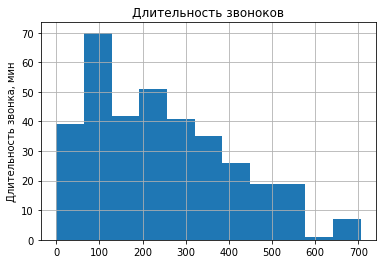

In [32]:
analis['duration'].hist(bins='auto')
plt.title('Длительность звоноков')
plt.ylabel('Длительность звонка, мин')
plt.show()

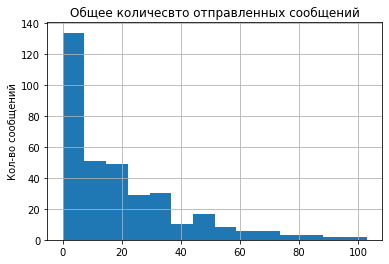

In [33]:
analis['id'].hist(bins='auto')
plt.title('Общее количесвто отправленных сообщений')
plt.ylabel('Кол-во сообщений')
plt.show()

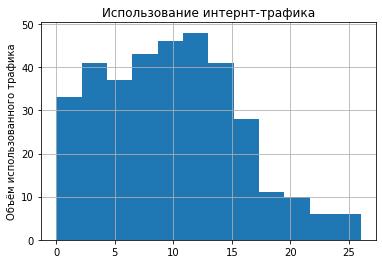

In [34]:
analis['gb_used'].hist(bins='auto')
plt.title('Использование интернт-трафика')
plt.ylabel('Объём использованного трафика')
plt.show()

На рисунке наглядно видно, что вывоводы сделанные на основе расчетов верны. Большая часть пользователей не привышает бесплатного лимита колличества сообщений, но немного привышает лимит израсходованных минут и интернета.

In [35]:
inf_smart['profit'].value_counts()

550.0     250
3550.0     10
3750.0     10
3950.0      6
4550.0      4
         ... 
2338.0      1
712.0       1
4059.0      1
6903.0      1
793.0       1
Name: profit, Length: 65, dtype: int64

Однако, если посмтореть данные по выручке, то видно, что лишь примерно 20% пользователей пользуется только основным пакетом услуг входящий в тариф. И судя по тому, как резуий разрыв в объёме суммы(на второй по количеству пользователей позиции доход в 3950), то можно предположить, что в основном такой разрыв появляется за счет дополнительной пкокупки Гб интернета, так как он самый дорогой из всех дополнительных услуг(200 руб. за 1 Гб).

### Посчитаем среднее количество, дисперсию и стандартное отклонение по тарифу ultra

In [36]:
a = total_inf.query('tariff == "ultra"')
a_1 = a.pivot_table(index='tariff', values=['duration', 'id', 'gb_used'],
                       aggfunc=['mean', 'std', 'var'])
a_1

mean                              std                       \
          duration    gb_used         id   duration   gb_used         id   
tariff                                                                     
ultra   301.202703  11.385135  31.864865  267.69609  8.259831  37.016387   

                 var                          
            duration    gb_used           id  
tariff                                        
ultra   71661.196727  68.224812  1370.212907

Судя по средним величинам, минуты и колличество сообщений не привышает беплатного лимита и не расходуется даже половины, а вот интернета  хватает. Проиллюстрируем на гистограмме

Среднее отклонение длительности завонков: 268

Среднее отклонение количесвто сообщений: 37

Среднее отклонение израсходованного интернет-трафика: 8

Дисперсия длительности завонков:  71661

Дисперсия количесвто сообщений:  1370

Дисперсия израсходованного интернет-трафика: 68

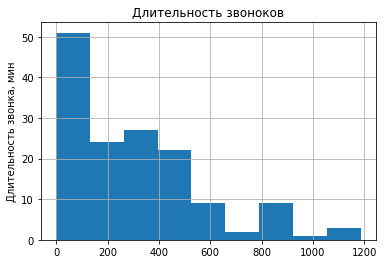

In [37]:
a['duration'].hist(bins='auto')
plt.title('Длительность звоноков')
plt.ylabel('Длительность звонка, мин')
plt.show()

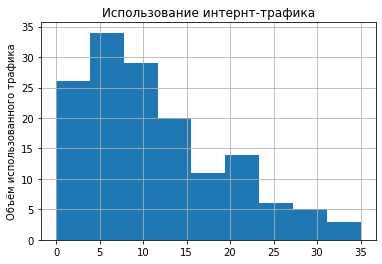

In [38]:
a['gb_used'].hist(bins='auto')
plt.title('Использование интернт-трафика')
plt.ylabel('Объём использованного трафика')
plt.show()

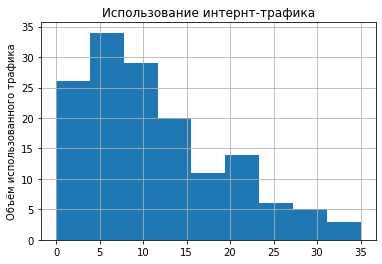

In [39]:
a['gb_used'].hist(bins='auto')
plt.title('Использование интернт-трафика')
plt.ylabel('Объём использованного трафика')
plt.show()

На рисунке наглядно видно, что вывоводы сделанные на основе расчетов верны. Минут и колличества сообщений, объём использованного интернет-трафика не привышает беплатного лимита.

In [40]:
inf_ultra['profit'].value_counts()

1950.0    143
6450.0      2
6900.0      1
7200.0      1
6750.0      1
Name: profit, dtype: int64

Посмотря статистику, около 85% пользователей тарифа "Ультра", пользуется только основным пакетом услуг входящий в тариф. Так как на гистограмме видно, что докупают пользователи, только интрнет трафик. Это и объяснет, такой разрыв в доходах от пользователей.

### Вывод
Проаналазировав данный о двух тарифах, можно сделать следующие выводы:

- Тариф "Смарт":

1. Колличество сообщений используется в рамках бесплатного тарифа

2. Колличество израсходованных минут и интернета превышает лимит

3. Большинство пользователей докупают дополнительные услуги (Гб интернета или минуты звонков)

- Тариф "Ультра":

1. Колличество  израсходованных минут и сообщений используется в рамках бесплатного тарифа

2. Пользователям не хватает только интернет-трафика и лишь иалой части клиентов

3. В общем малая часть нуждается в покупке дополнительных услуг.

## Проверка гипотез

### Гипотеза 1

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза (Н0) - средняя выручка тарифов одиникова

Альтернативная гипотеза - средняя выручка тарифов различается

In [41]:
smart_tt = inf_smart['profit']

In [42]:
ultra_tt = inf_ultra['profit'] 

In [43]:

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    smart_tt, 
    ultra_tt,
    equal_var=False)


print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Гипотеза неверна")
else:
    print("Гипотеза верна") 


p-значение: 2.5833427923530154e-07
Гипотеза неверна


Вероятность получить такое или большее различее случано около 0%.
Средняя выручка тарифов действительно разная, отвергаеи 0 гипотезу

### Гипотеза 2

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза (Н0) - средняя выручка пользователей из Москвы и из других регионов одинакова.

Альтернативная гипотеза - средняя выручка пользователей из Москвы и из других регионов различается.

In [44]:
ultra_moscow = inf_ultra.query('city == "Москва"')
smart_moscow = inf_smart.query('city == "Москва"')

ultra_nomoscow = inf_ultra.query('city != "Москва"')
smart_nomoscow = inf_smart.query('city != "Москва"')


In [45]:
msc = ultra_moscow['profit']
no_msc =ultra_nomoscow['profit']

msc1 = smart_moscow['profit']
nomsc1 = smart_nomoscow['profit']


In [46]:

alpha = .05 # уровень статистической значимости

results = st.ttest_ind( 
    msc,
    no_msc,
   equal_var=False)


print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Гипотеза неверна")
else:
    print("Гипотеза верна") 

p-значение: 0.9566882668240435
Гипотеза верна


Малая вероятность, чтобы делать вывод о разности между выборками. Принимаем 0 гипотезу.

In [47]:

alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    msc1, 
    nomsc1,
    equal_var=False)


print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Гипотеза неверна")
else:
    print("Гипотеза верна") 

p-значение: 0.9780893007301433
Гипотеза верна


Данные значения говрят  о том, что небольшой зачение р-значение не может характеризовать различия между выбраными территориальными зонами. Принимаем нулевую гипотезу. Не смотря на то, что выручка разная. 

## Вывод

В данном проекте мы проанализировали данный о пользователях:

- потраченных минут звоноков
- количестве отправленных сообщених
- потраченном интернет-трафики


В процессе изучения тарифов, были сделаны следующие выводы,а именно:

1. Количество сообщений и минут звонков в болшей части пользователей не превышала бесплатного лимита в двух тарифах.

2. Интернет-трафик в обоих предложениях превышает лимит, но в разных долях.

3. Так же мы выяснили, что выручка у тарифов разная.

4. Выручка между Москвой и регионами несильно различается.


Подводя итоги, определим лучший тариф:

Исходя из всех исследований в работе, мы выяснили,что чаще переплачивают за дополнительные усуги пользватели тарифа "Смарт", а значит пользователям даного тарифа(большинству) не хватает колличетсва услуг, входящих в базовый тариф. В основном переплачивают за интерет и звонки.  А в тарифе "Ультра" переплачивают за интернет, но гораздо меньшяя часть пользователей. 

Учитывая велечину и частоту перплаты по тарифу "Смарт" пользователями и то, что дополнительный 1Гб интернета там самый дорогой(тоже самое касается и дополнительних минут). То выходит выгоднее подключить тариф "Ультра". Несмотря на то, что количество пользователей разное в тарифах, даже если взять одинаковое число пользователей, процент использующий только базовый тариф людей, не будет таким большим как в тарифе "Ультра".